In [3]:
# Importando bibliotecas

from os import mkdir, path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import datetime
import seaborn as sns

In [4]:
# Funções úteis

def dt_to_unix_ns(date):
    return datetime.datetime.timestamp(date) * 1000 * 1000

def unix_ns_to_dt(x):
    return pd.to_datetime(x, unit='us', origin='unix')

def kb_to_mb(x):
    return x / 1000

def truncate_microseconds(date):
    return date.replace(microsecond=0)

def extract_metric(api_url, metric, filename):
    response = requests.get(f'{api_url}/api/metrics?metric={metric}')

    with open(filename, mode='wb') as f:
        f.write(response.content)

def extract_node(api_url):
    response = requests.get(f'{api_url}/api/health')

    data = response.json()

    return data.get('node', 'no-node')

def extract_data(path, nodes, api_urls):
    for api_url in api_urls:
        node = extract_node(api_url)

        nodes.append(node)

        for metric in metrics:
            extract_metric(api_url=api_url, metric=metric, filename=f'{path}/{node}-{metric}.csv')


def mkdir_if_not_exists(dir_path):
    if (not path.exists(dir_path)):
        mkdir(dir_path)

def read_metrics_data(path, filename, start_time, end_time):
    data = pd.read_csv(f'{path}/{filename}')

    data.columns = ['node', 'metric_name', 'label', 'measurement', 'time']

    # data = data[(data['time'] >= start_time) & (data['time'] <= end_time)]

    data['datetime'] = data['time'].apply(unix_ns_to_dt)
    # data['datetime'] = data['datetime'].apply(truncate_microseconds)

    data = data.set_index('datetime')

    data = data.sort_index()

    return data

In [25]:
# Definindo variáveis

scenarios = {
    'cenario-1': {
        'title': 'Cenário 1',
        'data_path': 'data/cenario-1',
        # Started at: 05/19/2022 19:28:07
        # Ended at: 05/19/2022 19:29:57
        'start_date': datetime.datetime(2022, 5, 19, 19, 25),
        'end_date': datetime.datetime(2022, 5, 19, 19, 40)
    },
    'cenario-2': {
        'title': 'Cenário 2',
        'data_path': 'data/cenario-2',
        # Started at: 05/19/2022 20:10:35
        # Ended at: 05/19/2022 20:12:25
        'start_date': datetime.datetime(2022, 5, 19, 20, 10),
        'end_date': datetime.datetime(2022, 5, 19, 20, 20)
    },
    'cenario-3': {
        'title': 'Cenário 3',
        'data_path': 'data/cenario-3',
        # Started at: 05/19/2022 20:54:10
        # Ended at: 05/19/2022 20:56:00
        'start_date': datetime.datetime(2022, 5, 19, 20, 50),
        'end_date': datetime.datetime(2022, 5, 19, 21, 10)
    },
    'cenario-4': {
        'title': 'Cenário 4',
        'data_path': 'data/cenario-4',
        # Started at: 05/20/2022 21:18:15
        # Ended at: 05/20/2022 21:20:08
        'start_date': datetime.datetime(2022, 5, 20, 21, 18),
        'end_date': datetime.datetime(2022, 5, 20, 21, 21),
        'plot_total_events_processed': True,
        'expected_events_processed': 20_000,
        'expected_messages_processed': 10_000
    }
}

metrics = [
    'vm.memory.total',
    'vm.system_counts.process_count',
    'vm.system_counts.atom_count',
    'vm.system_counts.port_count',
    'events.total',
    'events.process_time',
    'mqtt.total',
    'mqtt.process_time'
]

api_urls = ['http://localhost:4001', 'http://localhost:4002', 'http://localhost:4003']

for scenario in scenarios.keys():
    data_path = f'data/{scenario}'

    mkdir_if_not_exists(data_path)

    output_path = f'output/{scenario}'

    mkdir_if_not_exists(output_path)

nodes = ['fogex@node-1', 'fogex@node-2', 'fogex@node-3']

In [26]:
# Funções de plot

def plot_messages_throughput(scenario_name, title=None):
    datas = []
    scenario = scenarios.get(scenario_name)

    if not scenario:
        raise 'Scenario not found'

    start_date = scenario.get('start_date')
    end_date = scenario.get('end_date')

    start_date_in_unix_ns = dt_to_unix_ns(start_date)
    end_date_in_unix_ns = dt_to_unix_ns(end_date)

    data_path = scenario.get('data_path')

    metric = 'mqtt.total'

    for node in nodes:
        try:
            data = read_metrics_data(
                data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

            data['datetime in seconds'] = data['time'].apply(unix_ns_to_dt)
            data['datetime in seconds'] = data['datetime in seconds'].apply(
                truncate_microseconds)

            groups = data.groupby('datetime in seconds')

            new_data = groups.aggregate(len)

            datas.append((node, new_data))
        except:
            continue

    if title:
        plt.title(title)
    else:
        plt.title(scenario.get('title'))

    for (node, data) in datas:
        plt.plot(data['measurement'], label=node)

        plt.ylabel('Mensagens por segundo')
        plt.xlabel('Tempo')

    plt.legend()
    plt.grid()


def plot_events_throughput(scenario_name, title=None):
    datas = []
    scenario = scenarios.get(scenario_name)

    if not scenario:
        raise 'Scenario not found'

    start_date = scenario.get('start_date')
    end_date = scenario.get('end_date')

    start_date_in_unix_ns = dt_to_unix_ns(start_date)
    end_date_in_unix_ns = dt_to_unix_ns(end_date)

    data_path = scenario.get('data_path')
    metric = 'events.total'

    for node in nodes:
        try:
            data = read_metrics_data(
                data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

            data['datetime in seconds'] = data['time'].apply(unix_ns_to_dt)
            data['datetime in seconds'] = data['datetime in seconds'].apply(
                truncate_microseconds)

            groups = data.groupby('datetime in seconds')

            new_data = groups.aggregate(len)

            datas.append((node, new_data))
        except:
            continue

    if title:
        plt.title(title)
    else:
        plt.title(scenario.get('title'))

    for (node, data) in datas:
        plt.plot(data['measurement'], label=node)

        plt.ylabel('Eventos por segundo')
        plt.xlabel('Tempo')

    plt.legend()
    plt.grid()


def plot_messages_process_time(scenario_name, title=None):
    datas = []
    scenario = scenarios.get(scenario_name)

    if not scenario:
        raise 'Scenario not found'

    start_date = scenario.get('start_date')
    end_date = scenario.get('end_date')

    start_date_in_unix_ns = dt_to_unix_ns(start_date)
    end_date_in_unix_ns = dt_to_unix_ns(end_date)

    data_path = scenario.get('data_path')

    metric = 'mqtt.process_time'

    for node in nodes:
        try:
            data = read_metrics_data(
                data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

            datas.append((node, data))
        except:
            continue

    if title:
        plt.title(title)
    else:
        plt.title(scenario.get('title'))

    for (node, data) in datas:
        g = sns.boxplot(y=data['measurement'], data=data, width=0.5)

        g.set_ylabel('Tempo de processamento (ms)')
        g.set_xlabel('')

    plt.grid()


def plot_events_process_time(scenario_name, title=None):
    datas = []
    scenario = scenarios.get(scenario_name)

    if not scenario:
        raise 'Scenario not found'

    start_date = scenario.get('start_date')
    end_date = scenario.get('end_date')

    start_date_in_unix_ns = dt_to_unix_ns(start_date)
    end_date_in_unix_ns = dt_to_unix_ns(end_date)

    data_path = scenario.get('data_path')

    metric = 'events.process_time'

    for node in nodes:
        try:
            data = read_metrics_data(
                data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

            datas.append((node, data))
        except:
            continue

    if title:
        plt.title(title)
    else:
        plt.title(scenario.get('title'))

    for (node, data) in datas:
        g = sns.boxplot(x=data['label'],
                        y=data['measurement'], data=data, width=0.5)

        g.set_ylabel('Tempo de processamento (ms)')
        g.set_xlabel('')

    plt.grid()


def plot_memory_usage(scenario_name, title=None):
    datas = []
    scenario = scenarios.get(scenario_name)

    if not scenario:
        raise 'Scenario not found'

    start_date = scenario.get('start_date')
    end_date = scenario.get('end_date')

    start_date_in_unix_ns = dt_to_unix_ns(start_date)
    end_date_in_unix_ns = dt_to_unix_ns(end_date)

    data_path = scenario.get('data_path')

    metric = 'vm.memory.total'

    for node in nodes:
        data = read_metrics_data(
            data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

        data['measurement'] = data['measurement'].apply(kb_to_mb)

        datas.append((node, data))

    if title:
        plt.title(title)
    else:
        plt.title(scenario.get('title'))

    for (node, data) in datas:
        plt.plot(data['measurement'], label=node)

        plt.ylabel('Memória (MB)')
        plt.xlabel('Tempo')

    plt.legend()
    plt.grid()


def plot_message_and_events_loss(scenario_name, title=None):
    scenario = scenarios.get(scenario_name)

    if not scenario:
        raise 'Scenario not found'

    start_date = scenario.get('start_date')
    end_date = scenario.get('end_date')

    start_date_in_unix_ns = dt_to_unix_ns(start_date)
    end_date_in_unix_ns = dt_to_unix_ns(end_date)

    data_path = scenario.get('data_path')

    metric = 'events.total'
    expected_events_processed = scenario.get(
        'expected_events_processed'
    )

    events_processed = 0

    messages_processed = 0
    expected_messages_processed = scenario.get(
        'expected_messages_processed'
    )

    for node in nodes:
        try:
            data = read_metrics_data(
                data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)
        except:
            continue

        events_processed += data['measurement'].sum()

    metric = 'mqtt.total'


    for node in nodes:
        try:
            data = read_metrics_data(
                data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)
        except:
            continue

        messages_processed += data['measurement'].sum()

    if title:
        plt.title(title)
    else:
        plt.title(scenario.get('title'))


    width = 0.5
    missing_events = expected_events_processed - events_processed
    missing_messages = expected_messages_processed - messages_processed

    plt.bar('Mensagens (MQTT)', messages_processed, width, color='tab:green', label='Mensagens esperadas')
    plt.bar('Mensagens (MQTT)', missing_messages, width, bottom=messages_processed, color='tab:red', label='Mensagens/eventos perdidas')

    plt.bar('Eventos (Event Store)', events_processed, width, color='tab:blue', label='Eventos esperados')
    plt.bar('Eventos (Event Store)', missing_events, width, bottom=events_processed, color='tab:red')

    plt.ylabel('Total')

    plt.legend()


In [137]:
# Extraindo dados
scenario = 'cenario-4'
data_path = f'data/{scenario}'
nodes = []

extract_data(data_path, nodes, api_urls)

nodes

['fogex@node-1', 'fogex@node-2', 'fogex@node-3']

In [13]:
# Sandbox
scenario = 'cenario-3'

node = nodes[0]

start_date = scenarios[scenario].get('start_date')
end_data = scenarios[scenario].get('end_date')

start_date_in_unix_ns = dt_to_unix_ns(start_date)
end_date_in_unix_ns = dt_to_unix_ns(end_data)

data_path = f'data/{scenario}'

metric = 'events.total'

data = read_metrics_data(
            data_path, f'{node}-{metric}.csv', start_date_in_unix_ns, end_date_in_unix_ns)

data['datetime in seconds'] = data['time'].apply(unix_ns_to_dt)
data['datetime in seconds'] = data['datetime in seconds'].apply(
    truncate_microseconds)

groups = data.groupby('datetime in seconds')

new_data = groups.aggregate(len)

# data['time'] = data['time'].apply(unix_ns_to_dt)
# data['measurement'] = data['measurement'].apply(kb_to_mb)


new_data.describe()


,node,metric_name,label,measurement,time
count,231.000000,231.000000,231.000000,231.000000,231.000000
mean,216.445887,216.445887,216.445887,216.445887,216.445887
std,59.092083,59.092083,59.092083,59.092083,59.092083
min,92.000000,92.000000,92.000000,92.000000,92.000000
25%,175.000000,175.000000,175.000000,175.000000,175.000000
50%,187.000000,187.000000,187.000000,187.000000,187.000000
75%,261.000000,261.000000,261.000000,261.000000,261.000000
max,356.000000,356.000000,356.000000,356.000000,356.000000


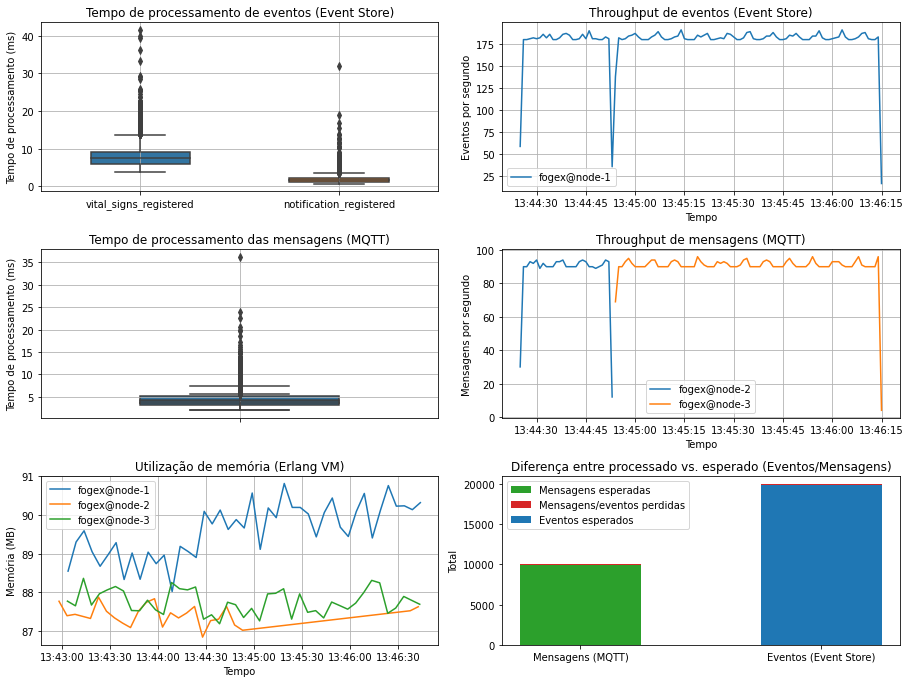

In [21]:
# Todos os gráficos por cenário

scenario_name = 'cenario-4'

default_figsize = (6.4, 4.8)
multiplier = (2, 2)

figsize = tuple(ele1 * ele2 for ele1, ele2 in zip(default_figsize, multiplier))

fig = plt.figure(figsize=figsize)

# Events process time

plt.subplot(3, 2, 1)

plot_events_process_time(
    scenario_name, title='Tempo de processamento de eventos (Event Store)')

# Events throughput

plt.subplot(3, 2, 2)

plot_events_throughput(
    scenario_name, title='Throughput de eventos (Event Store)')

# Messages process time

plt.subplot(3, 2, 3)

plot_messages_process_time(
    scenario_name, title='Tempo de processamento das mensagens (MQTT)')

# Messages throughput

plt.subplot(3, 2, 4)

plot_messages_throughput(scenario_name, title='Throughput de mensagens (MQTT)')

# Memory usage

plt.subplot(3, 2, 5)

plot_memory_usage(scenario_name, title='Utilização de memória (Erlang VM)')

# Expected vs processed events and messages

plot_total_events_processed = scenarios[scenario_name].get(
    'plot_total_events_processed',
    False
)

if (plot_total_events_processed):
    plt.subplot(3, 2, 6)

    plot_message_and_events_loss(
        scenario_name, title='Diferença entre processado vs. esperado (Eventos/Mensagens)')


# Show and save
plt.tight_layout()
plt.savefig(f'{output_path}/{scenario_name}.png')
plt.show()


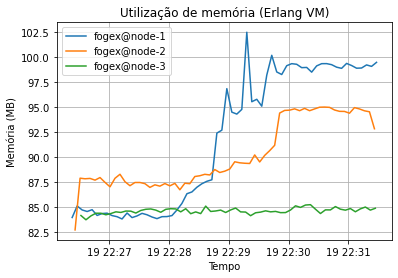

In [27]:
# Plotando a métrica vm.memory.total
plot_memory_usage('cenario-1', title='Utilização de memória (Erlang VM)')

plt.savefig(f'{output_path}/vm.memory.total.png')

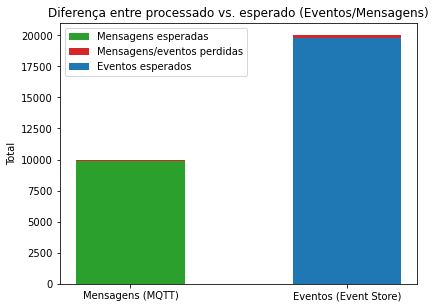

In [22]:
default_figsize = (6.4, 4.8)
multiplier = (1, 1)

figsize = tuple(ele1 * ele2 for ele1, ele2 in zip(default_figsize, multiplier))

fig = plt.figure(figsize=figsize)

plot_message_and_events_loss('cenario-4', title='Diferença entre processado vs. esperado (Eventos/Mensagens)')


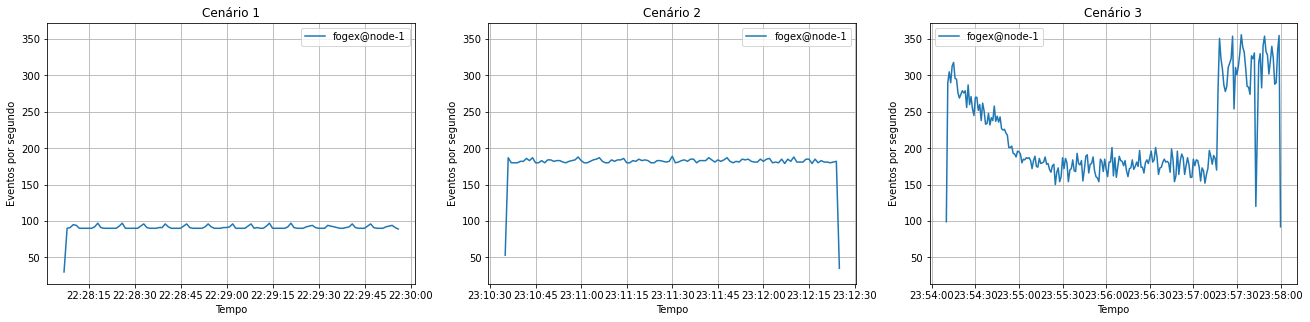

In [53]:
# Throughput de eventos por cenário
default_figsize = (6.4, 4.8)
multiplier = (3.5, 1)

figsize = tuple(ele1 * ele2 for ele1, ele2 in zip(default_figsize, multiplier))

fig = plt.figure(figsize=figsize)

ay1 = fig.add_subplot(1, 3, 1)

plot_events_throughput('cenario-1')

ay2 = fig.add_subplot(1, 3, 2, sharey=ay1)

plot_events_throughput('cenario-2')

ay3 = fig.add_subplot(1, 3, 3, sharey=ay2)

plot_events_throughput('cenario-3')

plt.savefig('output/throughput-de-eventos-por-cenario.png')
plt.show()


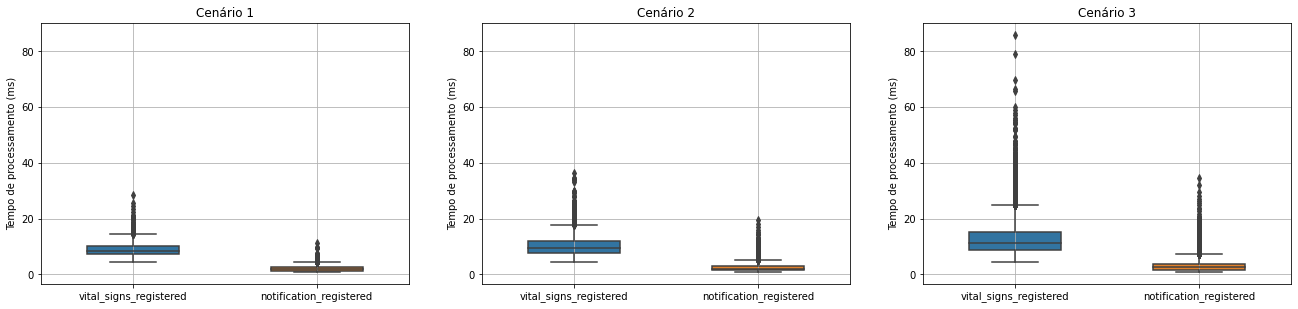

In [52]:
# Tempo de processamento de eventos por cenário
default_figsize = (6.4, 4.8)
multiplier = (3.5, 1)

figsize = tuple(ele1 * ele2 for ele1, ele2 in zip(default_figsize, multiplier))

fig = plt.figure(figsize=figsize)

ay1 = fig.add_subplot(1, 3, 1)

plot_events_process_time('cenario-1')

ay2 = fig.add_subplot(1, 3, 2, sharey=ay1)

plot_events_process_time('cenario-2')

ay3 = fig.add_subplot(1, 3, 3, sharey=ay2)

plot_events_process_time('cenario-3')

plt.savefig('output/tempo-processamento-de-eventos-por-cenario.png')
plt.show()


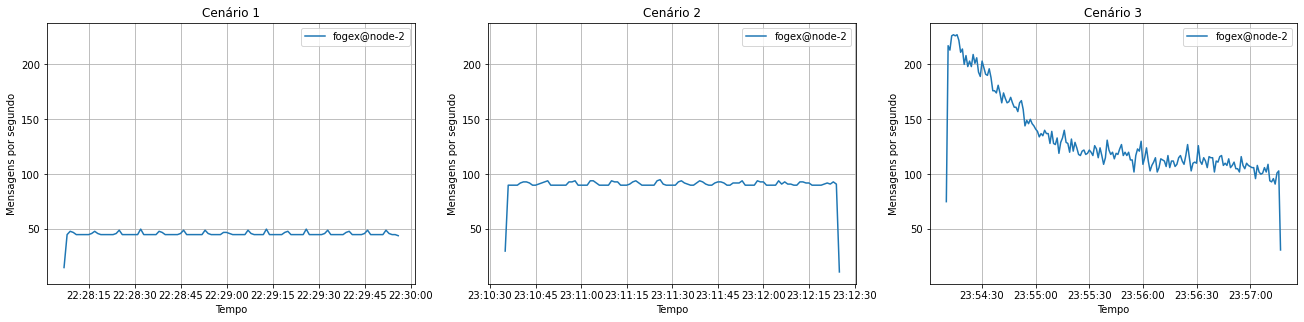

In [48]:
# Throughput de mensagens por cenário
default_figsize = (6.4, 4.8)
multiplier = (3.5, 1)

figsize = tuple(ele1 * ele2 for ele1, ele2 in zip(default_figsize, multiplier))

fig = plt.figure(figsize=figsize)

ay1 = fig.add_subplot(1, 3, 1)

plot_messages_throughput('cenario-1')

ay2 = fig.add_subplot(1, 3, 2, sharey=ay1)

plot_messages_throughput('cenario-2')

ay3 = fig.add_subplot(1, 3, 3, sharey=ay2)

plot_messages_throughput('cenario-3')

plt.savefig('output/throughput-de-mensagens-por-cenario.png')
plt.show()

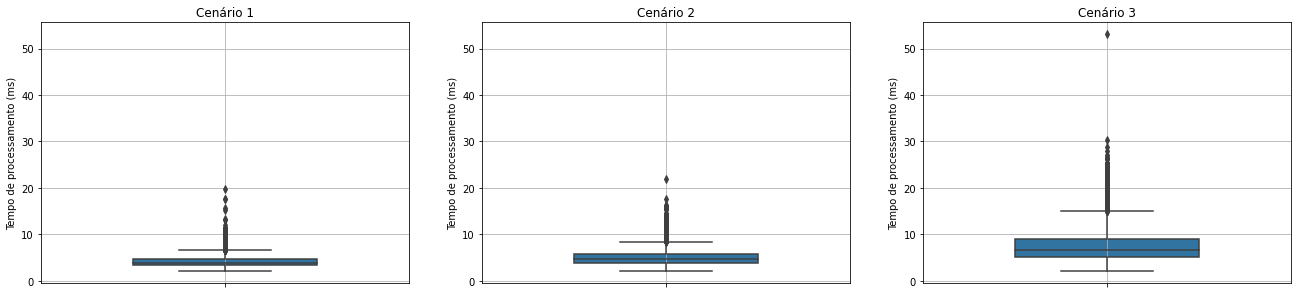

In [49]:
# Tempo de processamento de mensagens por cenário
default_figsize = (6.4, 4.8)
multiplier = (3.5, 1)

figsize = tuple(ele1 * ele2 for ele1, ele2 in zip(default_figsize, multiplier))

fig = plt.figure(figsize=figsize)

ay1 = fig.add_subplot(1, 3, 1)

plot_messages_process_time('cenario-1')

ay2 = fig.add_subplot(1, 3, 2, sharey=ay1)

plot_messages_process_time('cenario-2')

ay3 = fig.add_subplot(1, 3, 3, sharey=ay2)

plot_messages_process_time('cenario-3')

plt.savefig('output/tempo-de-processamento-de-mensagens-por-cenario.png')
plt.show()


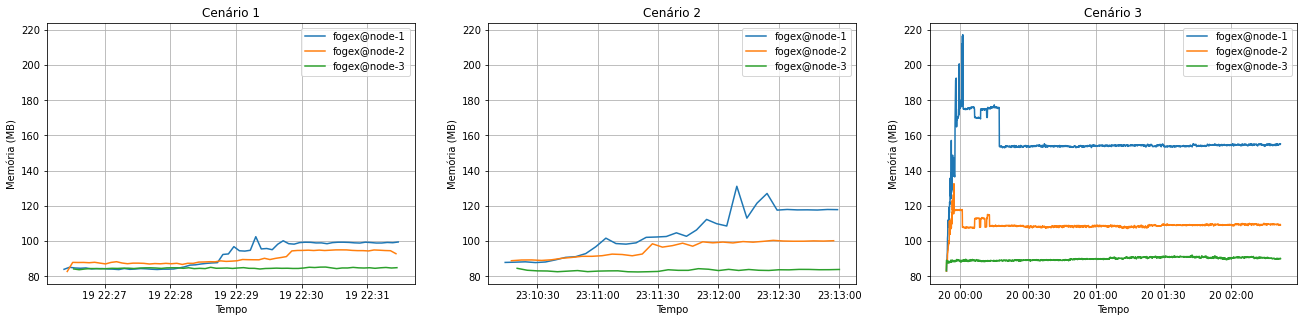

In [50]:
# Memória utilizada por cenário
default_figsize = (6.4, 4.8)
multiplier = (3.5, 1)

figsize = tuple(ele1 * ele2 for ele1, ele2 in zip(default_figsize, multiplier))

fig = plt.figure(figsize=figsize)

ay1 = fig.add_subplot(1, 3, 1)

plot_memory_usage('cenario-1')

ay2 = fig.add_subplot(1, 3, 2, sharey=ay1)

plot_memory_usage('cenario-2')

ay3 = fig.add_subplot(1, 3, 3, sharey=ay2)

plot_memory_usage('cenario-3')

plt.savefig('output/memoria-utilizada-por-cenario.png')
plt.show()


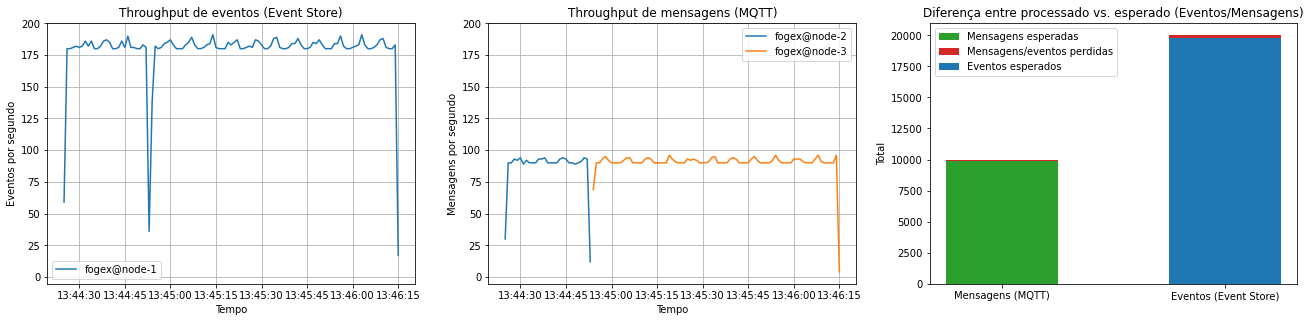

In [51]:
# Cenário 4
default_figsize = (6.4, 4.8)
multiplier = (3.5, 1)

figsize = tuple(ele1 * ele2 for ele1, ele2 in zip(default_figsize, multiplier))

fig = plt.figure(figsize=figsize)

shared = fig.add_subplot(1, 3, 1)

plot_events_throughput('cenario-4', title='Throughput de eventos (Event Store)')

fig.add_subplot(1, 3, 2, sharey=shared, sharex=shared)

plot_messages_throughput('cenario-4', title='Throughput de mensagens (MQTT)')

fig.add_subplot(1, 3, 3)

plot_message_and_events_loss('cenario-4', title='Diferença entre processado vs. esperado (Eventos/Mensagens)')

plt.savefig('output/cenario-4.png')

plt.show()